# Cavity Flow with Navier-Stokes


2次元のキャビティ流れを可視化します。

基礎方程式となるナビエストークスの運動方程式は以下の通りです。
$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v}=-\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}$$


$x$軸方向の速度を$u$、$y$軸方向の速度を$v$とし、圧力を $p$とすると、以下の式が成り立ちます。

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) $$


$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) $$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$

これを離散化して、近似解を求めます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# initial codition
nx = 50
ny = 50

nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

# cavity size
x = np.linspace(0, 10, nx)
y = np.linspace(0, 10, ny)
X, Y = np.meshgrid(x, y)

#  viscosity/density
rho = 1
nu = 0.1

# step
dt = 0.001

In [3]:
def build_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

In [4]:
def pressure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        # dp/dy = 0 at x = 2
        p[:, -1] = p[:, -2]
        
        # dp/dy = 0 at y = 0
        p[0, :] = p[1, :] 
        
        # dp/dx = 0 at x = 0
        p[:, 0] = p[:, 1] 
        
        # p = 0 at y = 2
        p[-1, :] = 0
        
    return p

In [5]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_b(b, rho, dt, u, v, dx, dy)
        p = pressure(p, dx, dy, b)
        
        
        # calculate x-axis velocity 
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        
        # calculate y-axis velocity 
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        u[-1, :] = 1
        v[0, :] = 0
        v[-1, :]=0
        v[:, 0] = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [6]:
def show_result(subplot, nt):
    
    # calculate cavity flow
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    b = np.zeros((ny, nx))
    u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)
    
    # plotting velocity field
    subplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
    subplot.set_title('CavityFlow nt=%.f' % nt)
    
    # plotting the pressure field 
    pf=subplot.contourf(X, Y, p, alpha=0.5) 
    plt.colorbar(pf)

    # plotting the pressure field outlines
    subplot.contour(X, Y, p)

    # set label
    subplot.set_xlabel('x')
    subplot.set_ylabel('y')

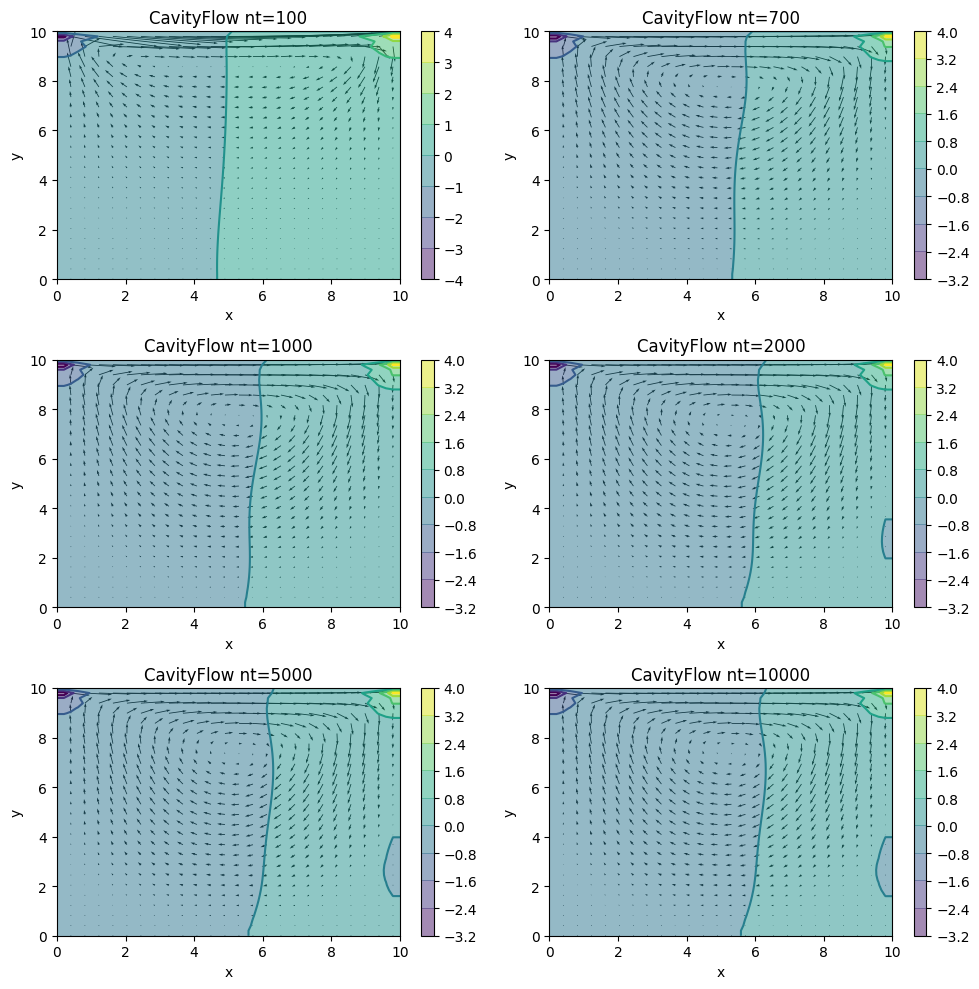

In [7]:
# create figure instance
fig = plt.figure(figsize=(10,10), dpi=100)

# show result
for i, nt in enumerate([100,700,1000,2000,5000,10000]):
    subplot = fig.add_subplot(3,2,i+1)
    show_result(subplot, nt)
    
plt.tight_layout()